# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:21<00:00, 1459.92it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_118904 = final['Summary'].values[118904]
print(sent_118904)
print("="*50)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

A classic


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

DELICIOUS


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [00:55<00:00, 2159.22it/s]


In [34]:
preprocessed_Summary = [118904]
print (preprocessed_Summary)

[118904]


# Time Based Splitting

In [35]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:50000])
print(final_20.shape)
final_20.head(3)

(50000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
49283,53526,B000UPALKO,A3IX1QVVNYF1BU,T. S. Femino,2,2,1,1205625600,"Best Drink Mix, Seriously",K2O is by far one of the greatest drinks out t...,far one greatest drinks easy mix dissolves ama...
48516,52722,B0017T2MWW,A3TTCOENJB6E7C,DS,0,0,1,1315008000,Love this green tea!,Absolutely love this green tea. This isn't fo...,absolutely love green tea not weak heart prett...
115978,125774,B000NVFDX0,A4SMNKA9PJEVG,L. jenkins,0,0,1,1349481600,very good quality for the price,I usually buy in France but ran out. Bought so...,usually buy france ran bought wholefoods not f...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [36]:
# sample dataset 
final_20['Score'].value_counts()

1    41976
0     8024
Name: Score, dtype: int64

In [37]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [38]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.231306081754735

In [39]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [40]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (50000,)


In [41]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (50000,)


In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
# from sklearn.model_selection import train_test_split

# split the data set into train and test
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33)
# print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_cv.shape, Y_cv.shape)

In [43]:
X = final_20['CleanedText'].values

Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 53600 points to train the model and 20000 points to test its performance on the test set.

# [4] Featurization

## [4.1] BAG OF WORDS

In [44]:
#BoW
#https://www.kaggle.com/rochachan/part-1-for-beginners-bag-of-words
from sklearn.feature_extraction.text import CountVectorizer    #in scikit-learn
count_vect = CountVectorizer(min_df = 20, max_features=500).fit(X) # Here I am fitting my CountVectorizer function  into X_train and Then transform into X_train and X_test. 
# we also use fit_transform method for training set. I am doind it for auc
# min_df = 20;min_df = 20, which will remove any words from our vocabulary that appear in fewer than five documents.
# https://towardsdatascience.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews-ea3b232c2c1b
X_bow = count_vect.transform(X)

print("After vectorizations")
print(X_bow.shape, y.shape)
print("="*100)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer :",type(X_bow))
print("the shape of out text BOW vectorizer : ",X_bow.get_shape())
print("the number of unique words :", X_bow.get_shape()[1])

After vectorizations
(50000, 500) (50000,)
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (50000, 500)
the number of unique words : 500


## [4.2] Bi-Grams and n-Grams.

In [45]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500).fit(X)
X_bow = count_vect.transform(X)
print("the type of count vectorizer ",type(X_bow))
print("the shape of out text BOW vectorizer ",X_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features=500).fit(X)
X_tf_idf = tf_idf_vect.transform(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_tf_idf.get_shape())
print("the number of unique words :", X_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (50000, 500)
the number of unique words : 500


In [47]:
print("the number of unique words :", X_tf_idf.get_shape()[1])

the number of unique words : 500


## [4.4] Word2Vec

## Preparing Reviews for gensim model

In [48]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
i=0
list_of_sentance_X=[]
for sentance in X:
    list_of_sentance_X.append(sentance.split())

## Training w2v model

In [49]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [50]:
# Train our own Word2Vec model using our own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_X,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
print('='*70)

[('awesome', 0.8400499224662781), ('good', 0.8214095830917358), ('fantastic', 0.8190536499023438), ('excellent', 0.8060511946678162), ('terrific', 0.7938928604125977), ('amazing', 0.7664972543716431), ('perfect', 0.7625691294670105), ('wonderful', 0.7619039416313171), ('decent', 0.6959947347640991), ('nice', 0.6950196623802185)]
[('best', 0.7641852498054504), ('greatest', 0.7346358895301819), ('nastiest', 0.7145366072654724), ('tastiest', 0.6503790616989136), ('smoothest', 0.6364830136299133), ('superior', 0.6343728303909302), ('experienced', 0.6089922785758972), ('closest', 0.6073471903800964), ('surpass', 0.5895845293998718), ('horrible', 0.5823980569839478)]


In [51]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13639
sample words  ['far', 'one', 'greatest', 'drinks', 'easy', 'mix', 'dissolves', 'amazingly', 'well', 'healthily', 'tastes', 'great', 'packet', 'contains', 'nice', 'fiber', 'protein', 'us', 'people', 'not', 'get', 'enough', 'days', 'strawberry', 'best', 'flavor', 'available', 'thus', 'friends', 'absolutely', 'love', 'green', 'tea', 'weak', 'heart', 'pretty', 'potent', 'stuff', 'although', 'ito', 'en', 'pure', 'also', 'good', 'similar', 'tasting', 'superior', 'waiting', 'amazon', 'back']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

## Algorithm: Avg W2V

#### [4.4.1.1] Avg W2v

In [52]:
from tqdm import tqdm
import numpy as np

In [53]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_X): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_X.append(sent_vec)
sent_vectors_X = np.array(sent_vectors_X)
print(sent_vectors_X.shape)
print(sent_vectors_X[0])

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:08<00:00, 388.07it/s]


(50000, 50)
[-0.2510526   0.05351458  1.14242336 -0.20368579 -0.04889847  0.25702018
 -0.1510257   0.05354223  0.62345867  0.71953926 -0.54129479  0.09057
  0.23994826 -0.20729159 -0.27372068  0.07527291 -0.15661432  0.30231421
 -0.36857697  0.3979422  -0.75869478 -0.36665873 -1.02432763  0.29770792
 -0.13375863  0.24721614 -0.30768278 -0.29287886 -0.5436465   0.21931677
  0.04113171  0.29155492  0.21143115  0.40028434 -0.02800881  0.95511387
 -0.44774723 -0.07549944 -0.28105754  0.12194514 -0.22580472 -0.03478124
 -0.6507038  -0.53037667 -0.61466782  0.43135239  0.40050389 -0.5738541
 -0.40091882 -0.15529807]


#### [4.4.1.2] TFIDF weighted W2v

In [86]:
from tqdm import tqdm
import numpy as np

In [87]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [88]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_X = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_X): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X.append(sent_vec)
    row += 1
tfidf_sent_vectors_X = np.array(tfidf_sent_vectors_X)
print(tfidf_sent_vectors_X.shape)
print(tfidf_sent_vectors_X[0])

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [31:39<00:00, 32.99it/s]


(50000, 50)
[-0.27488345  0.06752189  1.10807845 -0.04520345 -0.20472554  0.14675228
 -0.22914115  0.03069214  0.51375157  0.79352985 -0.45035481  0.07751247
  0.20613422 -0.15685972 -0.17834083  0.08536109 -0.09327923  0.29022888
 -0.45429002  0.26363057 -0.60604571 -0.40492604 -0.9987763   0.39478726
 -0.11033056  0.30508781 -0.31633709 -0.24809858 -0.50899191  0.34802036
 -0.04093293  0.30476198  0.32169671  0.37114562 -0.06037611  0.91336465
 -0.31952677 -0.02100738 -0.27407156  0.19363343 -0.2791948  -0.01348505
 -0.50153149 -0.34940602 -0.53994726  0.19331106  0.32185159 -0.48047886
 -0.44621106 -0.18785524]


In [89]:
print(len(tfidf_sent_vectors_X))
print(len(tfidf_sent_vectors_X[0]))

50000
50


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

# K-Means++ Implementation

In [54]:
# https://www.programcreek.com/python/example/85779/sklearn.cluster.KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

k_values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
inertia = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(X_bow)
    inertia.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████| 14/14 [3:00:40<00:00, 1200.78s/it]


# Hyper parameter Tuning

 # Elbow-knee method (plot k vs inertia_)

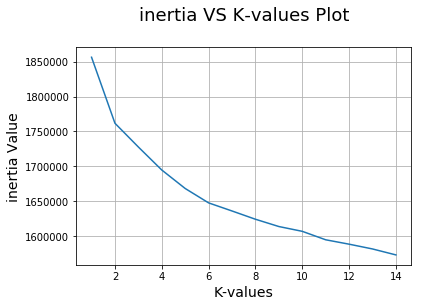

In [55]:
# Draw inertia VS K values plot
plt.plot(k_values, inertia)
plt.xlabel('K-values',size=14)
plt.ylabel('inertia Value',size=14)
plt.title('inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation(s):

1. Above we can see that there is inflection at K = 6 . 
2. Before it loss was decreasing faster as compared to the loss decreasing after it . 
3. So the best value of K is 6.

In [99]:
optimal_k = 6
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(X_bow)

In [100]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_k) ]
for i in range(kmeans.labels_.shape[0]):
    cluster[kmeans.labels_[i]].append(X[i])

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

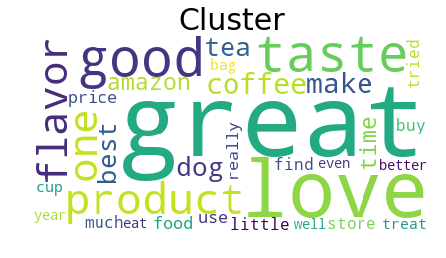

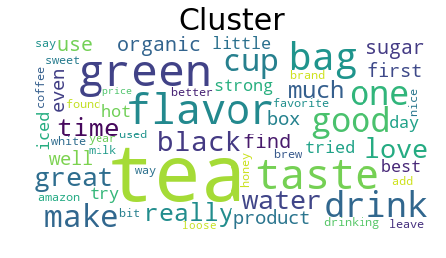

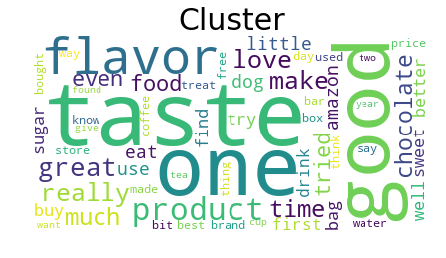

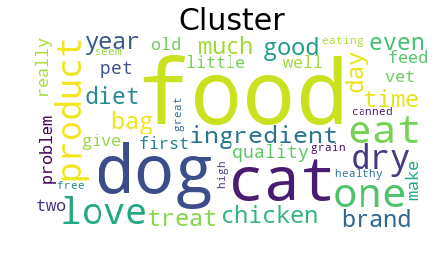

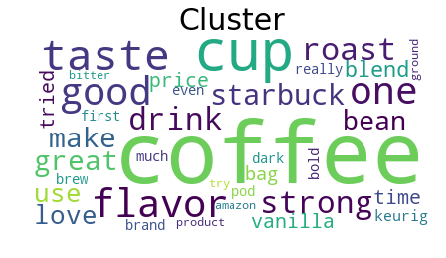

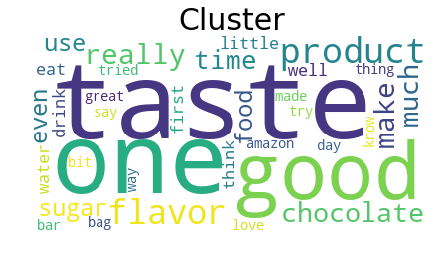

In [62]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(cluster_new):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster_new)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 6 clusters.
2. All clusters are showing different - different items.
3. Cluseter 4 is showing clusters of Animal related words(Dog, Cat, Chiken) and Cluseter 5 is showing clusters of Coffee related words(Coffee, Starbuck, Vanilla).

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [64]:
# https://www.programcreek.com/python/example/85779/sklearn.cluster.KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
inertia = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(X_tf_idf)
    inertia.append(kmeans.inertia_)

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:09:03<00:00, 540.42s/it]


# Hyper parameter Tuning

# Elbow-knee method (plot k vs inertia_)

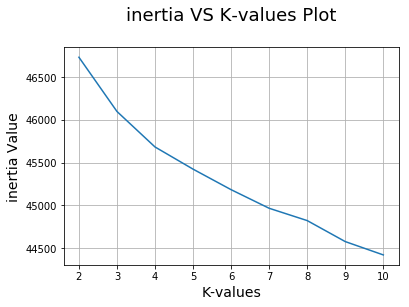

In [65]:
# Draw inertia VS K values plot
plt.plot(k_values, inertia)
plt.xlabel('K-values',size=14)
plt.ylabel('inertia Value',size=14)
plt.title('inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation(s):

1. Above we can see that there is inflection at K = 4. 
2. Before it loss was decreasing faster as compared to the loss decreasing after it . 
3. So the best value of K is 4.

In [102]:
optimal_k = 4
# Variable that will be used in the conclusion 
tf_idf_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(X_tf_idf)

In [104]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_k) ]
for i in range(kmeans.labels_.shape[0]):
    cluster[kmeans.labels_[i]].append(X[i])

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

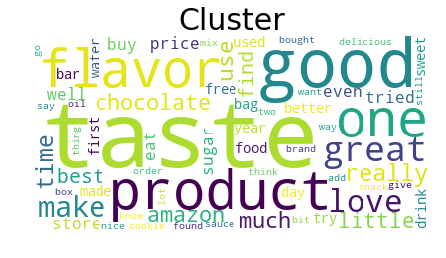

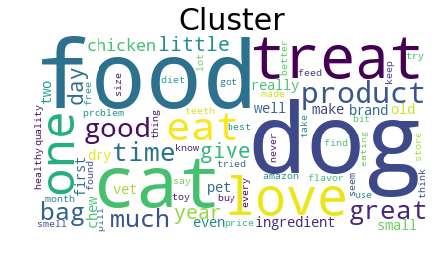

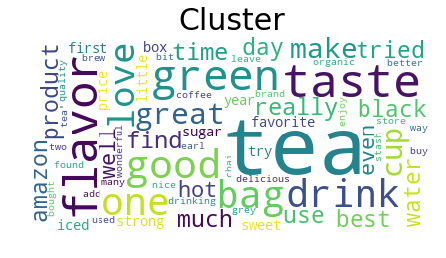

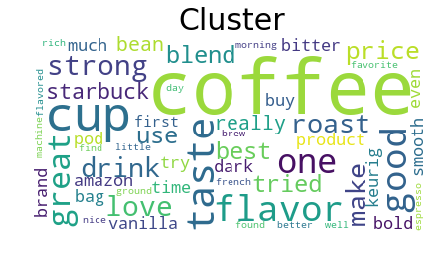

In [105]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(cluster_tf_idf):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster_tf_idf)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 4 clusters.
2. All clusters are showing different - different items.
3. Cluseter 2 is showing clusters of Animal related words(Dog, Cat, Chiken) and Cluseter 3 is showing clusters of Tea related words(Tea, Cup, GreenTea).

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [77]:
# https://www.programcreek.com/python/example/85779/sklearn.cluster.KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
inertia = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(sent_vectors_X)
    inertia.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:42<00:00, 12.47s/it]


# Hyper parameter Tuning

# Elbow-knee method (plot k vs inertia_)

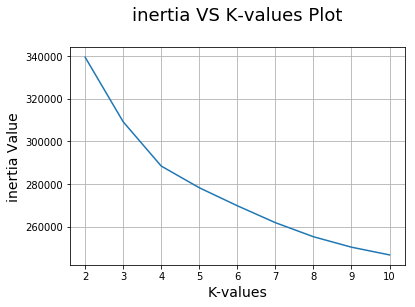

In [78]:
# Draw inertia VS K values plot
plt.plot(k_values, inertia)
plt.xlabel('K-values',size=14)
plt.ylabel('inertia Value',size=14)
plt.title('inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation(s):

1. Above we can see that there is inflection at K = 4. 
2. Before it loss was decreasing faster as compared to the loss decreasing after it . 
3. So the best value of K is 4.

In [85]:
optimal_k = 4
# Variable that will be used in the conclusion 
avg_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(sent_vectors_X)

In [80]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_k) ]
for i in range(kmeans.labels_.shape[0]):
    cluster[kmeans.labels_[i]].append(X[i])

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

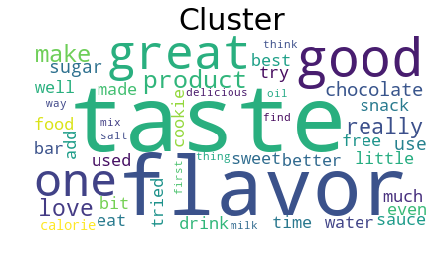

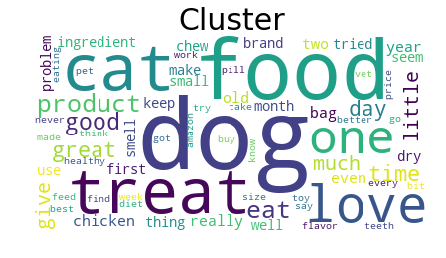

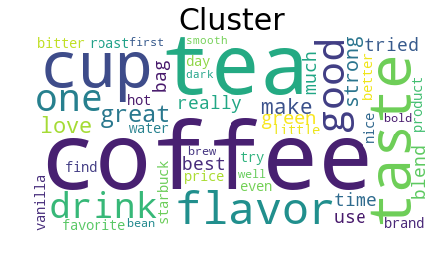

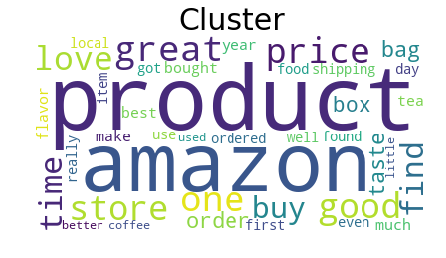

In [81]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(cluster_avg_w2v):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster_avg_w2v)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 4 clusters.
2. All clusters are showing different - different items.
3. Cluseter 2 is showing clusters of Animal related words(Dog, Cat, Chiken) and Cluseter 3 is showing Hot Drinks related words(Tea, Coffee, Taste).

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [90]:
# https://www.programcreek.com/python/example/85779/sklearn.cluster.KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
inertia = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(tfidf_sent_vectors_X)
    inertia.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:26<00:00,  9.67s/it]


# Hyper parameter Tuning

# Elbow-knee method (plot k vs inertia_)

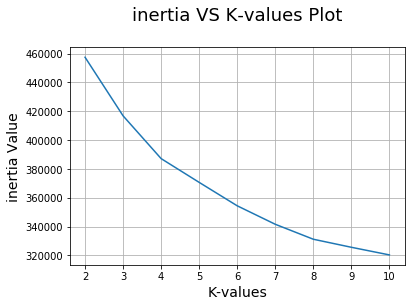

In [91]:
# Draw inertia VS K values plot
plt.plot(k_values, inertia)
plt.xlabel('K-values',size=14)
plt.ylabel('inertia Value',size=14)
plt.title('inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation(s):

1. Above we can see that there is inflection at K = 4. 
2. Before it loss was decreasing faster as compared to the loss decreasing after it . 
3. So the best value of K is 4.

In [92]:
optimal_k = 4
# Variable that will be used in the conclusion 
tf_idf_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(tfidf_sent_vectors_X)

In [93]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_k) ]
for i in range(kmeans.labels_.shape[0]):
    cluster[kmeans.labels_[i]].append(X[i])

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

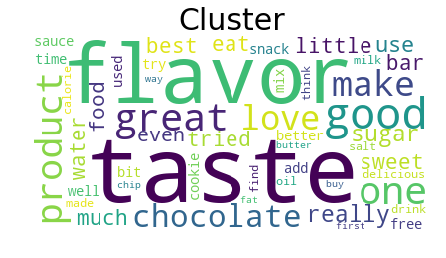

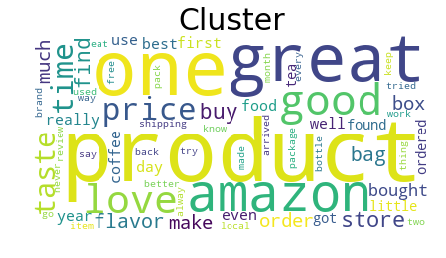

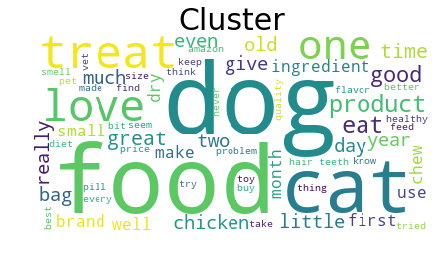

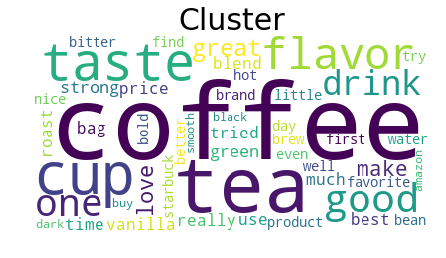

In [94]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(cluster_tfidf_w2v):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster_tfidf_w2v)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 4 clusters.
2. All clusters are showing different - different items.
3. Cluseter 3 is showing clusters of Animal related words(Dog, Cat, Chiken) and Cluseter 4 is showing Hot Drinks related words(Tea, Coffee, Taste).

## [5.2] Agglomerative Clustering(Hierarchical Clustering)

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [177]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
sent_vectors_X_standardized = sc.fit_transform(sent_vectors_X)

In [178]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
optimal_clusters = 2
# Variable that will be used in the conclusion 
avg_w2v_Agg_2 = optimal_clusters

# Implementing K-Means++ using optimal value of K
Agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters).fit(sent_vectors_X_standardized)

In [179]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_clusters) ]
for i in range(Agglomerative.labels_.shape[0]):
    cluster[Agglomerative.labels_[i]].append(X[i])

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

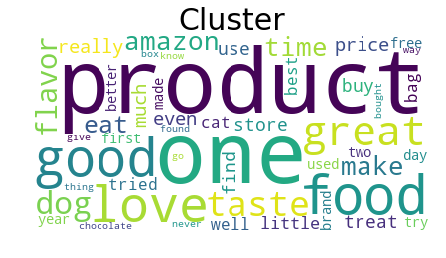

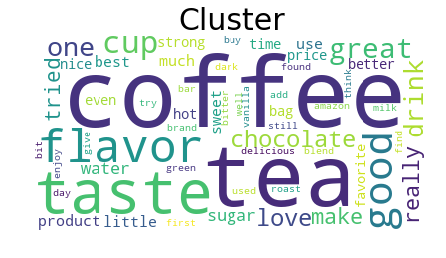

In [180]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(Agg_cluster_avg_w2v):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(Agg_cluster_avg_w2v)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 2 clusters.
2. All clusters are showing different - different items.
3. Cluseter 1 is showing clusters of online marketing related words(Amazon, Price, Product). Cluseter 2 is showing clusters Hot Drinks related words(Tea, Coffee, Taste).

In [181]:
optimal_clusters = 5
# Variable that will be used in the conclusion 
avg_w2v_Agg_5 = optimal_clusters

# Implementing K-Means++ using optimal value of K
Agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters).fit(sent_vectors_X_standardized)

In [182]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_clusters) ]
for i in range(Agglomerative.labels_.shape[0]):
    cluster[Agglomerative.labels_[i]].append(X[i])

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

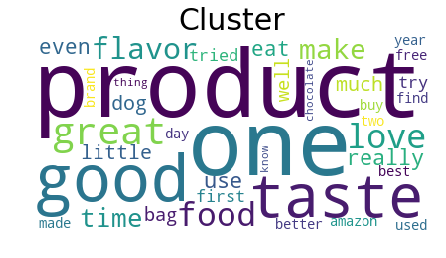

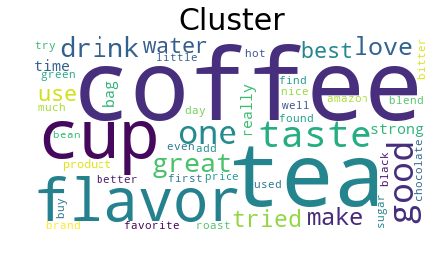

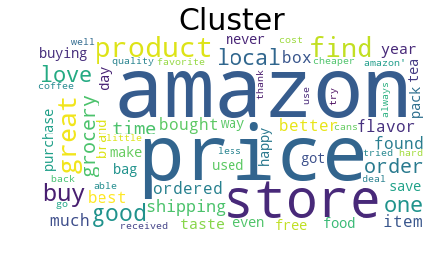

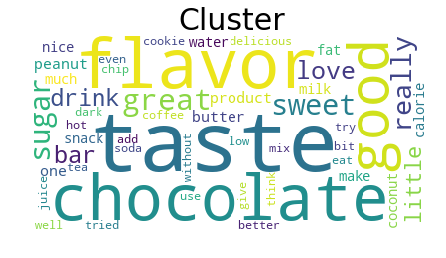

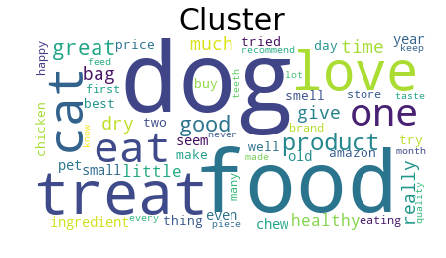

In [183]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(Agg_cluster_avg_w2v):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(Agg_cluster_avg_w2v)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 2 clusters.
2. All clusters are showing different - different items.
3. Cluseter 2 is showing clusters Hot Drinks related words(Tea, Coffee, Taste).Cluseter 3 is showing clusters of online marketing related words(Amazon, Price, Store).Cluseter 4 is showing clusters of Chocolate related words(Chocolate, Taste, Flavor).Cluseter 6 is showing clusters of Animal related words(Dog, Cat). 

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [185]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_X_standardized = sc.fit_transform(tfidf_sent_vectors_X)

In [186]:
optimal_clusters = 2
# Variable that will be used in the conclusion 
tf_idf_w2v_Agg_2 = optimal_clusters

# Implementing Agglomerative Clustering using optimal value of clusters
Agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters).fit(tfidf_sent_vectors_X)

In [187]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_clusters) ]
for i in range(Agglomerative.labels_.shape[0]):
    cluster[Agglomerative.labels_[i]].append(X[i])

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

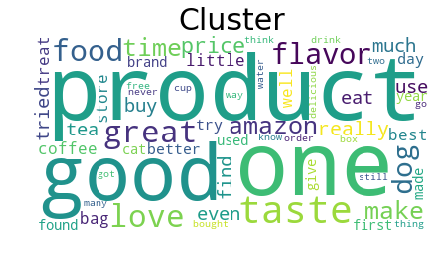

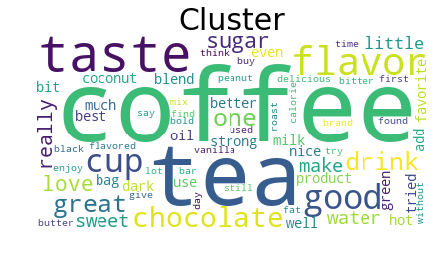

In [188]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(Agg_cluster_avg_w2v):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(Agg_cluster_avg_w2v)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 2 clusters.
2. All clusters are showing different - different items.
3. Cluseter 2 is showing clusters of online Hot drinks related words(Tea, Coffee, Taste). 

In [189]:
optimal_clusters = 5
# Variable that will be used in the conclusion 
tf_idf_w2v_Agg_5 = optimal_clusters

# Implementing Agglomerative Clustering using optimal value of clusters
Agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters).fit(tfidf_sent_vectors_X)

In [190]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_clusters) ]
for i in range(Agglomerative.labels_.shape[0]):
    cluster[Agglomerative.labels_[i]].append(X[i])

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

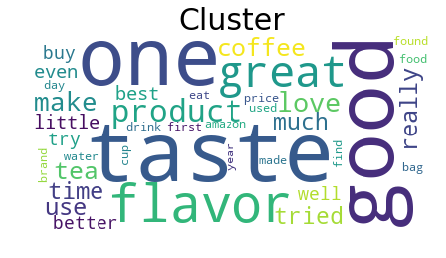

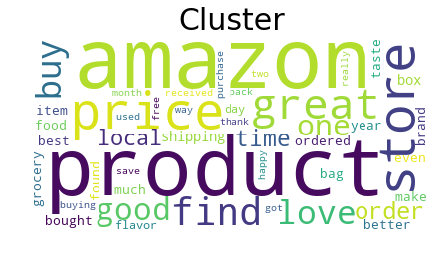

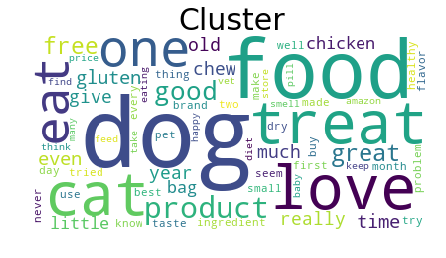

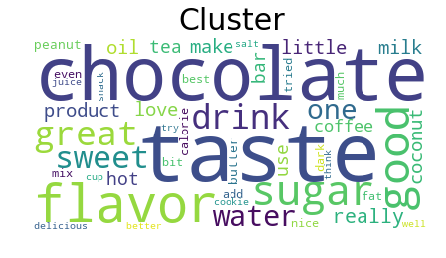

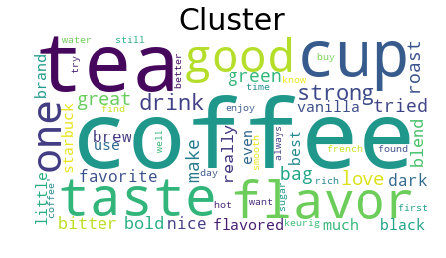

In [191]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(Agg_cluster_avg_w2v):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(Agg_cluster_avg_w2v)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 5 clusters.
2. All clusters are showing different - different items.
3. Cluseter 2 is showing clusters of online shoping related words(Amazon, Price, Store).Cluseter 3 is showing clusters of  Animal related words(Dog, Cat).Cluseter 4 is showing clusters of Chocolate related words(Chocolate, Taste, Flavor).Cluseter 5 is showing clusters Hot Drinks related words(Tea, Coffee, Taste).

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [197]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
sent_vectors_X_standardized = sc.fit_transform(sent_vectors_X)

In [242]:
from sklearn.neighbors import NearestNeighbors
min_point = 100
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(sent_vectors_X_standardized)
dist , index = knn.kneighbors(sent_vectors_X_standardized)

# Hyper parameter Tuning

# Elbow-knee method

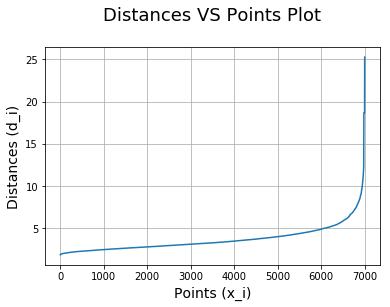

In [266]:
# Computing distances of nth-nearest neighbours
distances = n_neighbour(sent_vectors_X_standardized,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(sent_vectors_X_standardized.shape[0])]


# We choose hyperparameter eps(epsilon) by calculaing the distance from each points and sort them in 
# increasing order and then plot, where the knee occur we take it as the eps value from distance. 
# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

# DBSCAN Implementation

In [245]:
# https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
# https://stats.stackexchange.com/questions/79470/how-to-compare-dbscan-clusters-choose-epsilon-parameter?rq=1
# Typically, We choose min_points is equal to the 2 times of dimension of the data-points

optimal_eps = 8
# Variable that will be used in the conclusion 
avg_w2v_DB = optimal_eps

    
# Implementing K-DBSCAN using optimal value of eps
min_points = 100

db = DBSCAN(eps = 8 , min_samples = 100)
p = db.fit_predict(sent_vectors_X_standardized)

In [246]:
index = []
for i in range(len(p)):
    if p[i] == 0:
        index.append(i)
print(len(index))

6977


In [250]:
text = []
for i in range(len(index)):
    text.append(list_of_sentance_X[index[i]])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

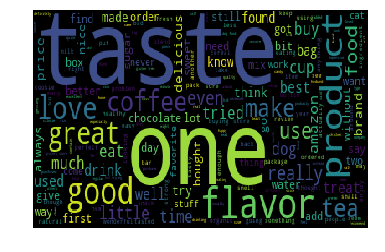

In [265]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

Observation(s):

1. We can see the word cloud of cluster formed in the image.
3. We can interpret what type of words are there in this cloud.
3. This Cluseter is showing cluster of Hot Drinks related words(Tea, Coffee, flavor).

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [267]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_X_standardized = sc.fit_transform(tfidf_sent_vectors_X)

# Hyper parameter Tuning

# Elbow-knee method

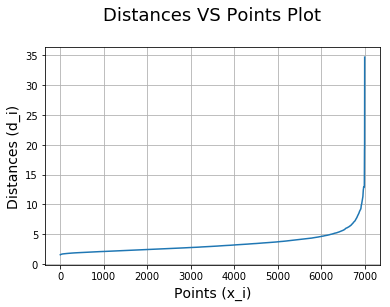

In [268]:
# Computing distances of nth-nearest neighbours
distances = n_neighbour(tfidf_sent_vectors_X_standardized,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(tfidf_sent_vectors_X_standardized.shape[0])]

# We choose hyperparameter eps(epsilon) by calculaing the distance from each points and sort them in 
# increasing order and then plot, where the knee occur we take it as the eps value from distance. 
# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

# DBSCAN Implementation

In [288]:
# https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
# https://stats.stackexchange.com/questions/79470/how-to-compare-dbscan-clusters-choose-epsilon-parameter?rq=1
# Typically, We choose min_points is equal to the 2 times of dimension of the data-points

optimal_eps = 5
# Variable that will be used in the conclusion 
tf_idf_w2v_DB = optimal_eps

    
# Implementing K-DBSCAN using optimal value of eps
min_points = 100

db = DBSCAN(eps = 5 , min_samples = 100)
p = db.fit_predict(tfidf_sent_vectors_X_standardized)

In [289]:
index = []
for i in range(len(p)):
    if p[i] == 0:
        index.append(i)
print(len(index))

6809


In [290]:
text = []
for i in range(len(index)):
    text.append(list_of_sentance_X[index[i]])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

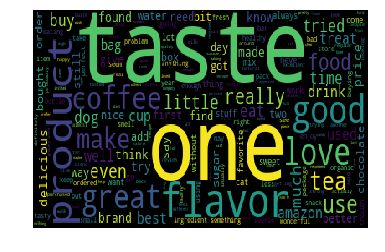

In [291]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

Observation(s):

1. We can see the word cloud of cluster formed in the image.
3. We can interpret what type of words are there in this cloud.
3. This Cluseter is showing cluster of Hot Drinks related words(Coffee, taste, flavor).

# [6] Conclusions

# Table for kmeans clustering

In [106]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['K-means++ for BoW','K-means++ for TFIDF','K-means++ for Avg_Word2Vec','K-means++ for tfidf_Word2Vec']

optimal_k = [bow_means_k,tf_idf_means_k,avg_w2v_means_k,tf_idf_w2v_means_k]

numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+------------------------------+---------------------+
| S.NO. |            MODEL             | Number of Clusters  |
+-------+------------------------------+---------------------+
|   1   |      K-means++ for BoW       |          6          |
|   2   |     K-means++ for TFIDF      |          4          |
|   3   |  K-means++ for Avg_Word2Vec  |          4          |
|   4   | K-means++ for tfidf_Word2Vec |          4          |
+-------+------------------------------+---------------------+


# Table for agllomerative clustering

In [194]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['Agllomerative Clustering for Avg_Word2Vec','Agllomerative Clustering for Avg_Word2Vec', \
         'Agllomerative Clustering for tfidf_Word2Vec','Agllomerative Clustering for tfidf_Word2Vec']

optimal_cluster = [avg_w2v_Agg_2,avg_w2v_Agg_5,tf_idf_w2v_Agg_2,tf_idf_w2v_Agg_5]

numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_cluster)

# Printing the Table
print(table)

+-------+---------------------------------------------+---------------------+
| S.NO. |                    MODEL                    | Number of Clusters  |
+-------+---------------------------------------------+---------------------+
|   1   |  Agllomerative Clustering for Avg_Word2Vec  |          2          |
|   2   |  Agllomerative Clustering for Avg_Word2Vec  |          5          |
|   3   | Agllomerative Clustering for tfidf_Word2Vec |          2          |
|   4   | Agllomerative Clustering for tfidf_Word2Vec |          5          |
+-------+---------------------------------------------+---------------------+


# Table for dbscan clustering

In [297]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['DBSCAN Clustering for Avg_Word2Vec','DBSCAN Clustering for tfidf_Word2Vec']

optimal_eps = [avg_w2v_DB,tf_idf_w2v_DB]

numbering = [1,2]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+--------------------------------------+---------------------+
| S.NO. |                MODEL                 | Number of Clusters  |
+-------+--------------------------------------+---------------------+
|   1   |  DBSCAN Clustering for Avg_Word2Vec  |          8          |
|   2   | DBSCAN Clustering for tfidf_Word2Vec |          5          |
+-------+--------------------------------------+---------------------+


# Procedure Followed:

STEP 1 : Loading The Data
    
STEP 2 : Data Cleaning: Deduplication

STEP 3 : Preprocessing Review Text

STEP 4 : Preprocessing Review Summary

STEP 5 : Sorting data according to Time in Ascending order.

STEP 6 : Applying Featurization Technique to convert text into vector.(i.e. BAG OF WORDS Model)

STEP 7 : Standardizing the data
    
STEP 8:- Applying Elbow Method using K-means++ in order to find optimal value of K(i.e. number of clusters)

STEP 9:- Draw inertia VS K-values plot

STEP 10:- Implementing K-Means++ using optimal value of K

STEP 11:- Wordclouds of clusters obtained after applying k-means on BOW

STEP 12 : Repeat STEP 6 to STEP 11 for TFIDF, Avg_w2v, TFIDF_w2v Vectorizer.

STEP 13 : Standardizing the data

STEP 14 : Applying Agglomerative Clustering on AVG W2V

STEP 15 : Implementing Agglomerative Clustering using optimal value of clusters.

STEP 16 : Wordclouds of clusters obtained after applying Agglomerative Clustering on W2V.

STEP 17 : Repeat STEP 13 to STEP 16 for TFIDF_w2v Vectorizer.

STEP 18 : Standardizing the data

STEP 19 : Applying DBSCSAN Clustering on AVG W2V

STEP 20:- Applying Elbow Method in order to find optimal value of Eps.

STEP 21:- Draw Distances VS Points Plot.

STEP 22:- Implementing DBSCAN using optimal value of EPS.

STEP 23:-  Wordclouds of clusters obtained after applying DBSCAN on AVG W2V.

STEP 24:- Repeat STEP 18 to STEP 23 for TFIDF_w2v Vectorizer.